In [1]:
import os
import glob
import warnings
import traceback

from multiprocessing import Pool

import tqdm
import pyart
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

warnings.simplefilter('ignore')

In [2]:
cluttermask = "../saved_mask/CLUTTER_map_CPOL_20061210.nc"
with netCDF4.Dataset(cluttermask, "r") as ncid:
    CLUTTER_RANGE = ncid['range'][:]
    CLUTTER_AZIMUTH = ncid['azimuth'][:]

In [3]:
def read_radar(infile, dbz_name='total_power'):
    with netCDF4.Dataset(infile, "r") as ncid:
        # Extract datetime
#         dtime = netCDF4.num2date(ncid['time'][0], ncid['time'].units)
        sweep = ncid["sweep_start_ray_index"][:]
        myslice = slice(sweep[0], sweep[1] - 1)
        dbz = ncid[dbz_name][myslice].filled(np.NaN)
        r = ncid['range'][:].filled(np.NaN)
        azi = ncid['azimuth'][myslice].filled(np.NaN)

    return r, azi, dbz

In [4]:
def extract_clutter(r, azi, r_mask, th_mask, reflec):
    """
    Extract reflectivity data that has the same (r, azi) as the clutter mask.

    Parameters:
    ===========
        radar: struct
            Py-ART radar structure.
        r_mask: numpy.array(float)
            Clutter range.
        th_mask: numpy.array(float)
            Clutter azimuth.
        dbz_name: str
            Reflectivity field name.

    Returns:
    ========
        clut: numpy.array(float)
            Extracted clutter reflectivity.
    """
    reflec[reflec < 10] = np.NaN
    dr = r[1] - r[0]
    # Angle variation tolerance
    dazi = 0.5

    clut = np.zeros(len(r_mask)) + np.NaN
    myr = []
    mya = []
    for cnt, (the_r, the_azi) in enumerate(zip(r_mask, th_mask)):
        pos_r = np.where((the_r >= r - dr) & (the_r < r + dr))[0]
        pos_azi = np.where((azi >= the_azi - dazi) & (azi < the_azi + dazi))[0]

        if (len(pos_r) > 0) & (len(pos_azi) > 0):  # Non-empty array
            if len(pos_r) == len(pos_azi):
                rtmp = pos_r
                ttmp = pos_azi
            else:
                rtmp = pos_r[0]
                ttmp = pos_azi[0]
        else:
            continue

        clut[cnt] = reflec[ttmp, rtmp]
        myr.append(the_r)
        mya.append(the_azi)

    return myr, mya, clut

In [5]:
def process_data(infile, dbz_name='DBZ'):
    try:
        r, azi, refl = read_radar(infile)
    except Exception:
        print(infile)
        raise
        
    rr, azi, clut = extract_clutter(r, azi, CLUTTER_RANGE, CLUTTER_AZIMUTH, refl)
    tmp = clut[~np.isnan(clut)]    
    try:
        rca = np.percentile(tmp, 95)
    except IndexError:
        rca = np.NaN

    return rr, azi, clut, rca

In [6]:
flist = glob.glob("/g/data2/rr5/CPOL_radar/CPOL_level_1b/PPI/2013/20130203/*.nc")

In [7]:
with Pool(16) as pool:
    rslt = list(tqdm.tqdm_notebook(pool.imap(process_data, flist), total=len(flist)))

In [24]:
flist[0]

'/g/data2/rr5/CPOL_radar/CPOL_level_1b/PPI/2013/20130203/cfrad.20130203_002002.000_to_20130203_002838.000_CPOL_PPI_level1b.nc'

In [9]:
rr, azi, clut, rca = rslt[0]

In [12]:
rr = np.array(rr)
azi = np.array(azi)

In [13]:
theta = 450 - azi
theta[theta >= 360] -= 360

In [14]:
theta *= np.pi / 180.

In [15]:
x = rr * np.cos(theta)
y = rr * np.sin(theta)

In [23]:
clut.shape

(965,)

ValueError: not enough values to unpack (expected 2, got 1)

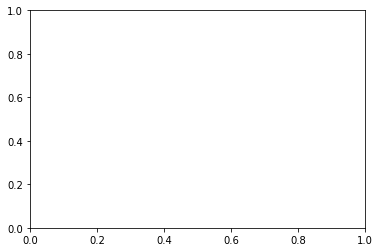

In [22]:
pl.pcolormesh(x, y, clut)
pl.show()

In [8]:
clutter = np.zeros((len(rslt), 60))
for cnt, (cl, rc) in enumerate(rslt):
    hist, bin_edges = np.histogram(cl, bins=60, range=[10, 70], normed=True)
    clutter[cnt, :] = hist    

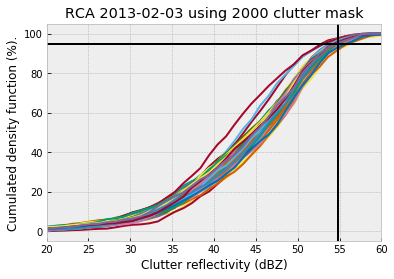

In [34]:
with pl.style.context('bmh'):
    pl.plot(np.linspace(15, 75, 60), 100 * np.cumsum(clutter, axis=1).T)
    pl.xlim(20, 60)
    pl.axhline(95, color='k')
    pl.axvline(54.8, color='k')
    pl.title('RCA 2013-02-03 using 2000 clutter mask')
    pl.xlabel('Clutter reflectivity (dBZ)')
    pl.ylabel('Cumulated density function (%).')
    pl.savefig('rca_2013_mask_2000.png', dpi=150)

In [6]:
flist = glob.glob("/g/data2/rr5/CPOL_radar/CPOL_level_1b/PPI/2006/20060101/*.nc")

In [7]:
with Pool(16) as pool:
    rslt = list(tqdm.tqdm_notebook(pool.imap(process_data, flist), total=len(flist)))

In [8]:
clutter = np.zeros((len(rslt), 60))
for cnt, (cl, rc) in enumerate(rslt):
    hist, bin_edges = np.histogram(cl, bins=60, range=[10, 70], normed=True)
    clutter[cnt, :] = hist    

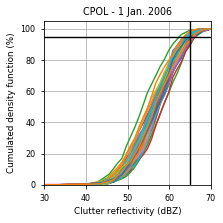

In [24]:
with pl.style.context('seaborn-paper'):
    fig = pl.figure()
    pl.plot(np.linspace(10, 70, 60), 100 * np.cumsum(clutter, axis=1).T)
    pl.xlim(30, 70)
    pl.ylim(0, 105)
    pl.axhline(95, color='k')
    pl.axvline(65, color='k')
    pl.title('CPOL - 1 Jan. 2006')
    pl.xlabel('Clutter reflectivity (dBZ)')
    pl.grid()
    pl.ylabel('Cumulated density function (%)')
    fig.set_size_inches((3.2, 3.2))
    fig.tight_layout()
    pl.savefig('nfig2.pdf')
    pl.savefig('nfig2.png', dpi=600)

In [109]:
cluttermask = "../saved_mask/CLUTTER_map_CPOL_20150101.nc"
with netCDF4.Dataset(cluttermask, "r") as ncid:
    CLUTTER_RANGE = ncid['range'][:]
    CLUTTER_AZIMUTH = ncid['azimuth'][:]

In [110]:
flist = glob.glob("/g/data2/rr5/CPOL_radar/CPOL_level_1b/PPI/2013/20130203/*.nc")

In [111]:
with Pool(16) as pool:
    rslt = list(tqdm.tqdm_notebook(pool.imap(process_data, flist), total=len(flist)))

In [112]:
clutter = np.zeros((len(rslt), 60))
for cnt, (cl, rc) in enumerate(rslt):
    hist, bin_edges = np.histogram(cl, bins=60, range=[10, 70], normed=True)
    clutter[cnt, :] = hist    

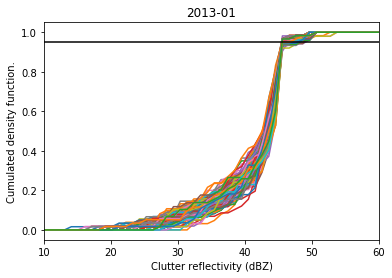

In [113]:
pl.plot(np.linspace(10, 70, 60), np.cumsum(clutter, axis=1).T)
pl.xlim(10, 60)
pl.axhline(0.95, color='k')
pl.title('2013-01')
pl.xlabel('Clutter reflectivity (dBZ)')
pl.ylabel('Cumulated density function.')
pl.show()

In [114]:
flist = glob.glob("/g/data2/rr5/CPOL_radar/CPOL_level_1b/PPI/2006/20060101/*.nc")

In [115]:
with Pool(16) as pool:
    rslt = list(tqdm.tqdm_notebook(pool.imap(process_data, flist), total=len(flist)))

In [116]:
clutter = np.zeros((len(rslt), 60))
for cnt, (cl, rc) in enumerate(rslt):
    hist, bin_edges = np.histogram(cl, bins=60, range=[10, 70], normed=True)
    clutter[cnt, :] = hist    

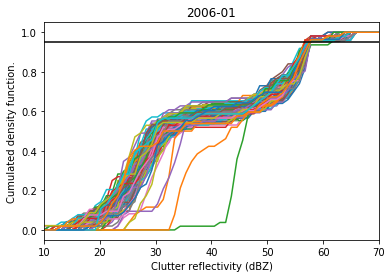

In [117]:
pl.plot(np.linspace(10, 70, 60), np.cumsum(clutter, axis=1).T)
pl.xlim(10, 70)
pl.axhline(0.95, color='k')
pl.title('2006-01')
pl.xlabel('Clutter reflectivity (dBZ)')
pl.ylabel('Cumulated density function.')
pl.show()